[**Dr. Kevin M. Moerman**](mailto:kevin.moerman@nuigalway.ie), _Lecturer in Biomedical Engineering_   

National University of Ireland Galway.   

---

\newpage

This is an [Octave](https://www.gnu.org/software/octave/) (an open source alternative to MATLAB) [Jupyter notebook](https://jupyter.org/)

\newpage

#### Defining variables 

In [2]:
%% Define parameters common to all examples

%Define material parameters
N=1; %The Ogden law order
mu1=0.5; %The shear modulus like parameter, set to 0.5 to be similar to FEBio's c1/2
m1=12; %The non-linearity parameter
k=1000; %Bulk modulus (used for uncoupled model)

%Derive applied stretch
appliedStretch=1.3; %Set applied stretch
nDataPoints=50; %Number of data points to use for evaluation and graph
lambda_3=linspace(1,appliedStretch,nDataPoints); %The 3 direction stretch

\newpage

## Uncoupled formulations
* Given the numerical difficulties in handling truely incompressible behaviour (theoretically requiring $\kappa=\infty$) a special class of constitutive formulations has been developed referred to as _uncoupled_ formulations.
  
  
* These uncoupled formulations are useful to model nearly-incompressible behaviour
  
  
* The term _uncoupled_ relates to the fact that strain energy density $\Psi$ is split into two additively seperated parts, namely: 
1. A purely _deviatoric_ (or isochoric = no volume change) part relating to shape change only $\Psi_{dev}$
1. A purely _volumetric_ part relating to volume change only $\Psi_{vol}$

$$\Psi=\Psi_{dev}+\Psi_{vol}$$

### Uncoupling the deformation
* To accomodate the split special shape and volume changing deformation metrics are required.   
  
  
* The Jacobian or volume ratio $J$ is already suitable  to describe volume change ($J=0.9$ means 10% volume loss, $J=1.1$ means 10% volume gain). 
  
* From the definition $J=\lambda_1\lambda_2\lambda_3$ one could imagine a single "spherical" average stretch $\lambda$ which is the same in all directions such that: 
$$J=\lambda_1\lambda_2\lambda_3=\lambda\lambda\lambda=\lambda^3 \rightarrow \lambda=J^{\frac{1}{3}}$$

* To "take away" the effect of this spherical volume changing stretch $\lambda$ from each of the stretches we can multiply them by $\frac{1}{\lambda}=J^{-\frac{1}{3}}$:
$$\tilde{\lambda}_i=J^{-\frac{1}{3}}\lambda_i$$

* This introduces the _deviatoric stretches_ denoted $\tilde{\lambda}_i$

* We can check if these deviatoric stretches really only change the shape by computing $\tilde{J}$ which should be 1 in magnitude for all stretches: 
$$\tilde{J}=\tilde{\lambda}_1\tilde{\lambda}_2\tilde{\lambda}_3=J^{-\frac{1}{3}}\lambda_1J^{-\frac{1}{3}}\lambda_2J^{-\frac{1}{3}}\lambda_3=J^{-\frac{1}{3}}J^{-\frac{1}{3}}J^{-\frac{1}{3}}\lambda_1\lambda_2\lambda_3=\frac{1}{J}J=1$$

### The uncoupled Ogden formulation from ABAQUS

* The [ABAQUS user manual](https://abaqus-docs.mit.edu/2017/English/SIMACAEMATRefMap/simamat-c-hyperelastic.htm) defines the uncoupled Ogden formulation as: 
 
$$\Psi(\tilde{\lambda}_1,\tilde{\lambda}_2,\tilde{\lambda}_3)=\sum_{a=1}^{N} \frac{2\mu_a}{\alpha_a^2}\big(\tilde{\lambda}_1^{\alpha_a}+\tilde{\lambda}_2^{\alpha_a}+\tilde{\lambda}_3^{\alpha_a}-3\big)+\frac{1}{D_a}(J^{el}-1)^{2a}$$

*Note that here we prefer to use $a$ as the summation index, since $i$ is often used as an index for the principal components e.g. $\lambda_i$.

* The Jacobian appears as $J^{el}$ to denote elastic volume changes (as apposed to thermal or other sources), however, we focus only on elastic deformations here and can therefore use $J^{el}=J$. Leading to: 

$$\Psi(\tilde{\lambda}_1,\tilde{\lambda}_2,\tilde{\lambda}_3)=\sum_{a=1}^{N} \frac{2\mu_a}{\alpha_a^2}\big(\tilde{\lambda}_1^{\alpha_a}+\tilde{\lambda}_2^{\alpha_a}+\tilde{\lambda}_3^{\alpha_a}-3\big)+\frac{1}{D_a}(J-1)^{2a}$$

* Furthermore the literature most often features a Bulk modulus, rather than $D$ parameters. For the above $\kappa=\kappa_0$ can be defined as
$$\kappa={\frac{2}{D_1}}$$
    
* We can also choose to use all equal $D_a$ values such that $D=D_1=D_2=\ldots$, and use $\frac{1}{D}=\frac{\kappa}{2}$ leading to: 

$$\Psi(\tilde{\lambda}_1,\tilde{\lambda}_2,\tilde{\lambda}_3)=\sum_{a=1}^{N} \frac{2\mu_a}{\alpha_a^2}\big(\tilde{\lambda}_1^{\alpha_a}+\tilde{\lambda}_2^{\alpha_a}+\tilde{\lambda}_3^{\alpha_a}-3\big)+\frac{\kappa}{2}(J-1)^{2a}$$

* Finally we could denote the $\alpha$ parameters as $m$ instead to have the form look most similar to the FEBio implementation: 
$$\Psi(\tilde{\lambda}_1,\tilde{\lambda}_2,\tilde{\lambda}_3)=\sum_{a=1}^{N} \frac{2\mu_a}{m_a^2}\big(\tilde{\lambda}_1^{m_a}+\tilde{\lambda}_2^{m_a}+\tilde{\lambda}_3^{m_a}-3\big)+\frac{\kappa}{2}(J-1)^{2a}$$

* The main difference with the FEBio implementatio is not the power over the last term and the use of $2\mu_a$ rather than simply $c_a$

* Now we can recognise the volumetric and deviatoric contributions as:
$$\Psi_{vol}=\sum_{a=1}^{N} \frac{1}{D_a}(J-1)^{2a}=\frac{\kappa}{2}\sum_{a=1}^{N} (J-1)^{2a}$$
    and
$$\Psi_{dev}=\sum_{a=1}^{N} \frac{2\mu_a}{m_a^2}\big(\tilde{\lambda}_1^{m_a}+\tilde{\lambda}_2^{m_a}+\tilde{\lambda}_3^{m_a}-3\big)$$

* The principal Cauchy stresses $\sigma_i$ can be computed from: 

$$\boldsymbol{\sigma}=\boldsymbol{\sigma}_{vol}+\boldsymbol{\sigma}_{dev}$$

* The volumetric stress $\boldsymbol{\sigma}_{vol}$ is derived from: 
$$\boldsymbol{\sigma}_{vol}=p\mathbf{I}$$ 
  
    where the hydrostatic pressure is now derived directly from the constitutive equation:  
    
    $$p=\frac{\partial \Psi_{vol}}{\partial J}=\sum_{a=1}^{N} \frac{2a}{D_a}(J-1)^{2a-1}=\kappa \sum_{a=1}^{N}a(J-1)^{2a-1}$$
    
    resulting in: 
    $$\boldsymbol{\sigma}_{vol}=\kappa\bigg( \sum_{a=1}^{N}a(J-1)^{2a-1} \bigg) \mathbf{I}$$


* The deviatoric stress $\boldsymbol{\sigma}_{dev}$ is derived from: 
$${\sigma_{dev_i}}=J^{-1} \lambda_i \frac{\partial \Psi_{dev}}{\partial \lambda_i}=J^{-1} \bigg( \tilde{\lambda}_i \frac{\partial \Psi_{dev}}{\partial \tilde{\lambda}_i} -\frac{1}{3}\sum_{j=1}^3\tilde{\lambda}_j \frac{\partial \Psi_{dev}}{\partial \tilde{\lambda}_j } \bigg)$$  

  
* Since $J=\lambda_1 \lambda_2 \lambda_3$, and $\lambda_1=\lambda_2$ (due to uniaxial loading in the 3rd direction) we can derive:  

$$J=\lambda_1 \lambda_2 \lambda_3 = \lambda_1 \lambda_1 \lambda_3 = \lambda_1^2 \lambda_3 $$
$$\rightarrow \lambda_1=\lambda_2= \sqrt{\frac{J}{\lambda_3}}$$
  
* Using 
$$\tilde{\lambda_i} \frac{\partial \Psi_{dev}}{\partial \tilde{\lambda}_i}=\sum_{a=1}^{N} \frac{2\mu_a}{m_a}\tilde{\lambda}_i^{m_a}$$

    we can formulate
$$\sigma_{dev_i}=J^{-1} \sum_{a=1}^{N} \frac{2\mu_a}{m_a} \bigg( \tilde{\lambda}_i^{m_a} -\frac{1}{3} \bigg( \tilde{\lambda}_1^{m_a} + \tilde{\lambda}_2^{m_a} + \tilde{\lambda}_3^{m_a} \bigg) \bigg)$$ 

$$\sigma_{dev_i}=J^{-1} \sum_{a=1}^{N} \frac{2\mu_a}{m_a} \bigg( \tilde{\lambda}_i^{m_a} -\frac{1}{3} \bigg( \tilde{\lambda}_1^{m_a} + \tilde{\lambda}_2^{m_a} + \tilde{\lambda}_3^{m_a} \bigg) \bigg)$$ 

* Since $\tilde{\lambda}_1\tilde{\lambda}_2\tilde{\lambda}_3=1$ one may use $\tilde{\lambda}_1=\tilde{\lambda}_2=\sqrt{\frac{1}{\tilde{\lambda}_3}}={\tilde{\lambda}_3}^{-\frac{1}{2}}$, and therefore: 
$$\sigma_{dev_i}=J^{-1} \sum_{a=1}^{N} \frac{2\mu_a}{m_a} \bigg( \tilde{\lambda}_i^{m_a} -\frac{1}{3} \bigg( 2\tilde{\lambda}_3^{-\frac{m_a}{2}} + \tilde{\lambda}_3^{m_a} \bigg) \bigg)$$ 

* Leading to:
$$\sigma_i=\kappa \sum_{a=1}^{N}a(J-1)^{2a-1} + J^{-1} \sum_{a=1}^{N}\frac{2\mu_a}{m_a} \bigg( \tilde{\lambda}_i^{m_a} -\frac{1}{3} \bigg( 2\tilde{\lambda}_3^{-\frac{m_a}{2}} + \tilde{\lambda}_3^{m_a} \bigg) \bigg)$$ 

* Which using $\tilde{\lambda}_1=\tilde{\lambda}_2={\tilde{\lambda}_3}^{-\frac{1}{2}}$ gives the following for $\sigma_1$ and $\sigma_2$: 
$$\sigma_1=\sigma_2=\kappa \sum_{a=1}^{N}a(J-1)^{2a-1} + J^{-1} \sum_{a=1}^{N}\frac{2\mu_a}{m_a} \bigg( \tilde{\lambda}_3^{-\frac{m_a}{2}} -\frac{1}{3} \bigg( 2\tilde{\lambda}_3^{-\frac{m_a}{2}} + \tilde{\lambda}_3^{m_a} \bigg) \bigg)=0$$ 

* Which using $\tilde{\lambda_3}=J^{-\frac{1}{3}}\lambda_3$ can be expressed in terms of $\lambda_3$ as:
$$\sigma_1=\sigma_2=\kappa \sum_{a=1}^{N}a(J-1)^{2a-1}+ J^{-1} \sum_{a=1}^{N} \frac{2\mu_a}{m_a} \bigg( (J^{-\frac{1}{3}}\lambda_3)^{-\frac{m_a}{2}} -\frac{1}{3} \bigg( 2(J^{-\frac{1}{3}}\lambda_3)^{-\frac{m_a}{2}} + (J^{-\frac{1}{3}}\lambda_3)^{m_a} \bigg) \bigg)=0$$ 

* Numerical metods are now needed to solve for J such that $\sigma_1=\sigma_2=0$ 

* **Note/tip**: To achieve nearly incompressible behaviour ($J\approx1$), the bulk modulus $\kappa$ is often set several orders of magnitude higher than the effective shear modulus (e.g. $\mu_1$ here). The codes here use $\kappa=1000 \mu_1$.

\newpage

### Numerical implementation
#### Compute stresses

In [3]:
%% The uncoupled formulation 
% One approach is to define a function for S1 and to find the J for which it is zero. 
% For this application the fzero function is useful to find J for S1(J)=0.

a1=1; %The first a, use a1=1 and a2=2 for a second order form etc. 

%Compute Jacobian given boundary conditions S1=S2=0
J=zeros(size(lambda_3)); %Initialize an arry of J values which are all zeros
for q=1:1:nDataPoints %Loop over all data points
    %Create stress function with current lambda
    S1_fun=@(J) k*a1*(J-1).^(2*a1-1)+(1./J)*((2*mu1)/m1)*( (J^(-1/3)*lambda_3(q))^(-m1/2)-...
    (1/3)*(2*(J^(-1/3)*lambda_3(q))^(-m1/2)+(J^(-1/3)*lambda_3(q))^m1) );     
    
    %Find Jacobian for zero stress, use J=1 as initial
    J(q)=fzero(S1_fun,1); %Find root of nonlinear function   
end

%Compute transverse stretches using J values
lambda_1=sqrt(J./lambda_3);
lambda_2=lambda_1; %Due to uniaxial loading

%Compute principal stresses (note, these are not ordered)
%Compute principal stresses (note, these are not ordered)
part2=(1/3)*((J.^(-1/3).*lambda_1).^m1+(J.^(-1/3).*lambda_2).^m1+(J.^(-1/3).*lambda_3).^m1);

S1=k*a1*(J-1).^(2*a1-1)+(1./J).*(((2*mu1)/m1).*((J.^(-1/3).*lambda_1).^m1-part2));
S2=k*a1*(J-1).^(2*a1-1)+(1./J).*(((2*mu1)/m1).*((J.^(-1/3).*lambda_2).^m1-part2)); 
S3=k*a1*(J-1).^(2*a1-1)+(1./J).*(((2*mu1)/m1).*((J.^(-1/3).*lambda_3).^m1-part2)); 

#### Visualize stresses

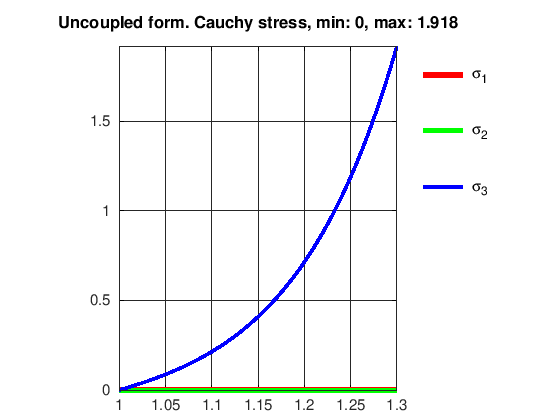

In [4]:
%Visualize stress graphs
figure; hold on; 
title(['Uncoupled form. Cauchy stress, min: ',num2str(min(S3(:))),...
', max: ',num2str(max(S3(:)))]); %Add title
h1=plot(lambda_3,S1,'r-','LineWidth',20); %The 1 direction principal stress
h2=plot(lambda_3,S2,'g-','LineWidth',15); %The 2 direction principal stress
h3=plot(lambda_3,S3,'b-','LineWidth',10); %The 3 direction principal stress
hl=legend([h1 h2 h3],{'\sigma_1','\sigma_2','\sigma_3'}); %Add legend
set(hl,'FontSize',15,'Location','NorthEastOutside','Box','off'); %Adjust legend
axis tight; axis square; grid on; box on; 
set(gca,'FontSize',15);

#### Visualize Jacobian

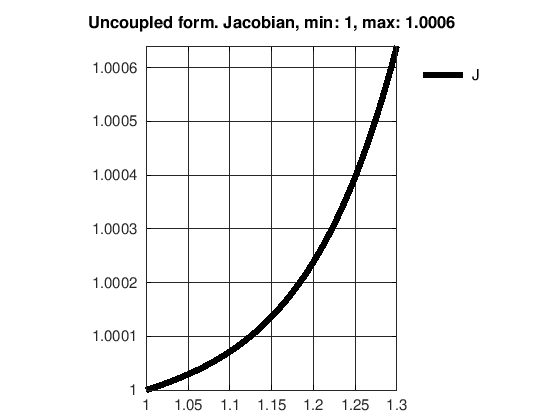

In [5]:
%Visualize Jacobian
figure; hold on; 
title(['Uncoupled form. Jacobian, min: ',num2str(min(J(:))),...
', max: ',num2str(max(J(:)))]); %Add title
h1=plot(lambda_3,J,'k-','LineWidth',20); %The 1 direction principal stress
hl=legend([h1],{'J'}); %Add legend
set(hl,'FontSize',15,'Location','NorthEastOutside','Box','off'); %Adjust legend
axis tight; axis square; grid on; box on; 
set(gca,'FontSize',15);